# Solar Flare Nanoflare Detection Analysis

This notebook analyzes GOES X-ray sensor data to detect nanoflares using enhanced visualizations and curve fitting techniques.

## Objectives:
- Load and truncate the 2022 XRSA/XRSB flux data to 1day=1440 samples
- Create enhanced visualizations using Seaborn
- Plot log-scale flux vs time for both XRSA and XRSB channels
- Baseline correction using pybaseline 
- filtering using savgol/gaussian filter
- Implement curve fitting to detect nanoflare signatures
- Identify potential nanoflare events

In [211]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.optimize import curve_fit
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set enhanced style for modern visualizations
plt.style.use('ggplot')  # Use 'ggplot' instead of 'ggplot2'
sns.set_palette("husl")  # Changed from "husl" - more professional colors
sns.set_context("notebook", font_scale=1.4, rc={"lines.linewidth": 2.5})  # Enhanced context

# Set superior aesthetic style for publication-quality visualizations
plt.style.use('seaborn-v0_8-whitegrid')  # Clean, professional base style
sns.set_palette("deep")  # Rich, vibrant color palette

# Configure context for optimal readability
sns.set_context("paper", font_scale=1.3, rc={
    "lines.linewidth": 2.8,
    "patch.linewidth": 0.5,
    "axes.linewidth": 1.5
})

# === PREMIUM MATPLOTLIB STYLING ===
plt.rcParams.update({
    # Figure and layout
    'figure.facecolor': '#ffffff',
    'figure.edgecolor': 'none',
    'savefig.facecolor': '#ffffff',
    'savefig.edgecolor': 'none',
    'savefig.dpi': 300,
    
    # Axes styling
    'axes.facecolor': '#fafafa',
    'axes.edgecolor': '#333333',
    'axes.linewidth': 1.5,
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.labelpad': 10,
    
    # Grid styling
    'axes.grid': True,
    'grid.color': '#e0e0e0',
    'grid.linestyle': '-',
    'grid.linewidth': 0.8,
    'grid.alpha': 0.7,
    
    # Text and fonts
    'font.family': [ 'Segoe UI', 'DejaVu Sans', 'Arial', 'sans-serif'],
    'font.size': 11,
    'font.weight': 'normal',
    'text.color': '#2c3e50',
    'axes.labelcolor': '#2c3e50',
    'axes.titleweight': 'bold',
    'axes.titlesize': 13,
    'axes.titlepad': 15,
    
    # Ticks
    'xtick.color': '#34495e',
    'ytick.color': '#34495e',
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'xtick.major.width': 1.2,
    'ytick.major.width': 1.2,
    'xtick.minor.width': 0.8,
    'ytick.minor.width': 0.8,
    
    # Legend
    'legend.frameon': True,
    'legend.fancybox': True,
    'legend.shadow': True,
    'legend.framealpha': 0.95,
    'legend.facecolor': '#ffffff',
    'legend.edgecolor': '#cccccc',
    'legend.fontsize': 10,
    'legend.title_fontsize': 11,
    
    # Lines and markers
    'lines.linewidth': 2.5,
    'lines.markersize': 6,
    'lines.markeredgewidth': 0.5,
    
    # Patches
    'patch.linewidth': 0.5,
    'patch.facecolor': '#3498db',
    'patch.edgecolor': '#2980b9',
    'patch.force_edgecolor': True,
    
    # Figure title
    'figure.titlesize': 16,
    'figure.titleweight': 'bold'
})


print("Libraries imported successfully!")

Libraries imported successfully!


In [212]:
# Load the CSV data
data_path = 'data/2023_xrsa_xrsb.csv'
df = pd.read_csv(data_path)

print(f"Original dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print("\nFirst few rows:")
print(df.head())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

Original dataset shape: (525600, 4)
Columns: ['time_minutes', 'time_seconds', 'xrsa_flux_observed', 'xrsb_flux_observed']

First few rows:
   time_minutes  time_seconds  xrsa_flux_observed  xrsb_flux_observed
0             0             0        8.923480e-08            0.000002
1             1            60        8.247599e-08            0.000001
2             2           120        7.758199e-08            0.000001
3             3           180        7.542049e-08            0.000001
4             4           240        7.351816e-08            0.000001

Missing values:
time_minutes              0
time_seconds              0
xrsa_flux_observed    16181
xrsb_flux_observed    16181
dtype: int64


In [213]:
# Clean the data and remove rows with missing values
df_clean = df.dropna()
print(f"Dataset shape after removing NaN values: {df_clean.shape}")

# Truncate to 0 to 1440 samples as requested
df_truncated = df_clean.iloc[:6*60].copy()
#df_truncated = df_clean.head(2000).copy()
print(f"Truncated dataset shape: {df_truncated.shape}")

# Display basic statistics
print("\nBasic statistics of truncated dataset:")
print(df_truncated.describe())

Dataset shape after removing NaN values: (509419, 4)
Truncated dataset shape: (360, 4)

Basic statistics of truncated dataset:
       time_minutes  time_seconds  xrsa_flux_observed  xrsb_flux_observed
count    360.000000    360.000000        3.600000e+02        3.600000e+02
mean     179.500000  10770.000000        7.211997e-08        1.553000e-06
std      104.067286   6244.037156        5.299252e-08        5.134851e-07
min        0.000000      0.000000        3.686430e-08        1.114782e-06
25%       89.750000   5385.000000        4.953594e-08        1.240643e-06
50%      179.500000  10770.000000        5.884392e-08        1.417723e-06
75%      269.250000  16155.000000        7.011617e-08        1.609120e-06
max      359.000000  21540.000000        3.909671e-07        3.861059e-06


In [214]:
# Prepare data for analysis
time_minutes = df_truncated['time_minutes'].values
xrsa_flux = df_truncated['xrsa_flux_observed'].values
xrsb_flux = df_truncated['xrsb_flux_observed'].values

# Calculate log values (handle potential zero or negative values)
# Add small epsilon to avoid log(0)
epsilon = 1e-12
log_xrsa = np.log10(np.maximum(xrsa_flux, epsilon))
log_xrsb = np.log10(np.maximum(xrsb_flux, epsilon))

print(f"Time range: {time_minutes.min():.1f} to {time_minutes.max():.1f} minutes")
print(f"XRSA flux range: {xrsa_flux.min():.2e} to {xrsa_flux.max():.2e}")
print(f"XRSB flux range: {xrsb_flux.min():.2e} to {xrsb_flux.max():.2e}")
print(f"Log XRSA range: {log_xrsa.min():.2f} to {log_xrsa.max():.2f}")
print(f"Log XRSB range: {log_xrsb.min():.2f} to {log_xrsb.max():.2f}")

Time range: 0.0 to 359.0 minutes
XRSA flux range: 3.69e-08 to 3.91e-07
XRSB flux range: 1.11e-06 to 3.86e-06
Log XRSA range: -7.43 to -6.41
Log XRSB range: -5.95 to -5.41


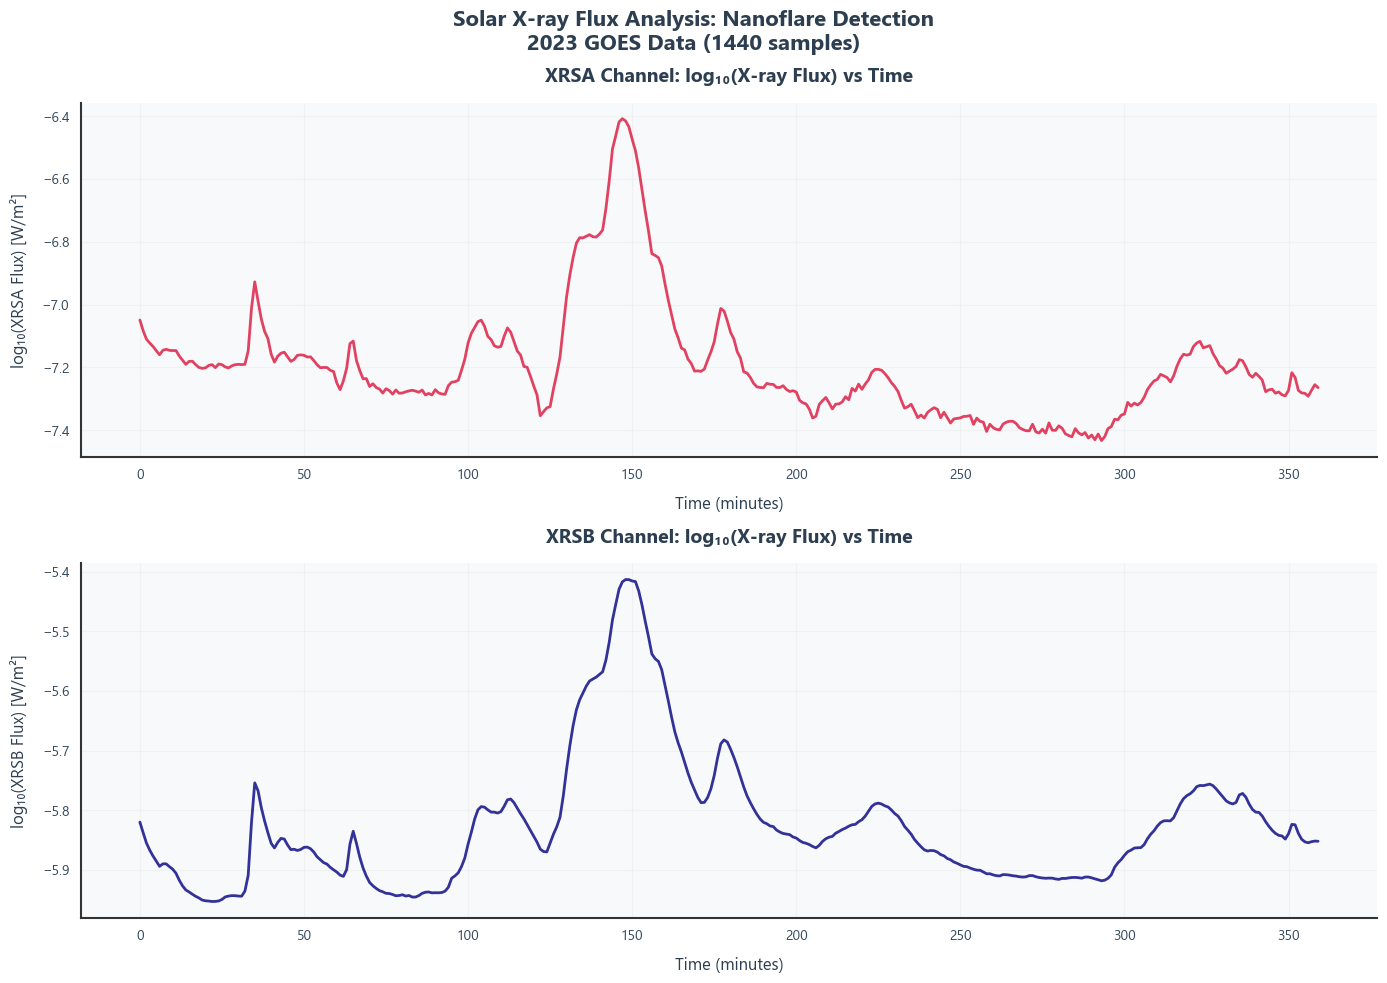

Enhanced visualization created successfully!


In [215]:
# Create enhanced visualizations using Seaborn
fig, axes = plt.subplots(2, 1, figsize=(14, 10))
fig.suptitle('Solar X-ray Flux Analysis: Nanoflare Detection\n2023 GOES Data (1440 samples)', 
             fontsize=16, fontweight='bold')

# Plot 1: log(XRSA flux) vs time
sns.lineplot(x=time_minutes, y=log_xrsa, ax=axes[0], 
             color='crimson', linewidth=2, alpha=0.8)
axes[0].set_title('XRSA Channel: log₁₀(X-ray Flux) vs Time', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Time (minutes)', fontsize=12)
axes[0].set_ylabel('log₁₀(XRSA Flux) [W/m²]', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].set_facecolor('#f8f9fa')

# Plot 2: log(XRSB flux) vs time
sns.lineplot(x=time_minutes, y=log_xrsb, ax=axes[1], 
             color='navy', linewidth=2, alpha=0.8)
axes[1].set_title('XRSB Channel: log₁₀(X-ray Flux) vs Time', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Time (minutes)', fontsize=12)
axes[1].set_ylabel('log₁₀(XRSB Flux) [W/m²]', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].set_facecolor('#f8f9fa')

plt.tight_layout()
plt.show()

print("Enhanced visualization created successfully!")

Now I want to flat the baseline of (log(xrsa) vs time ) using baseline correction . 


also baseline correction to log(xrsb) vs time 

pybaselines already installed


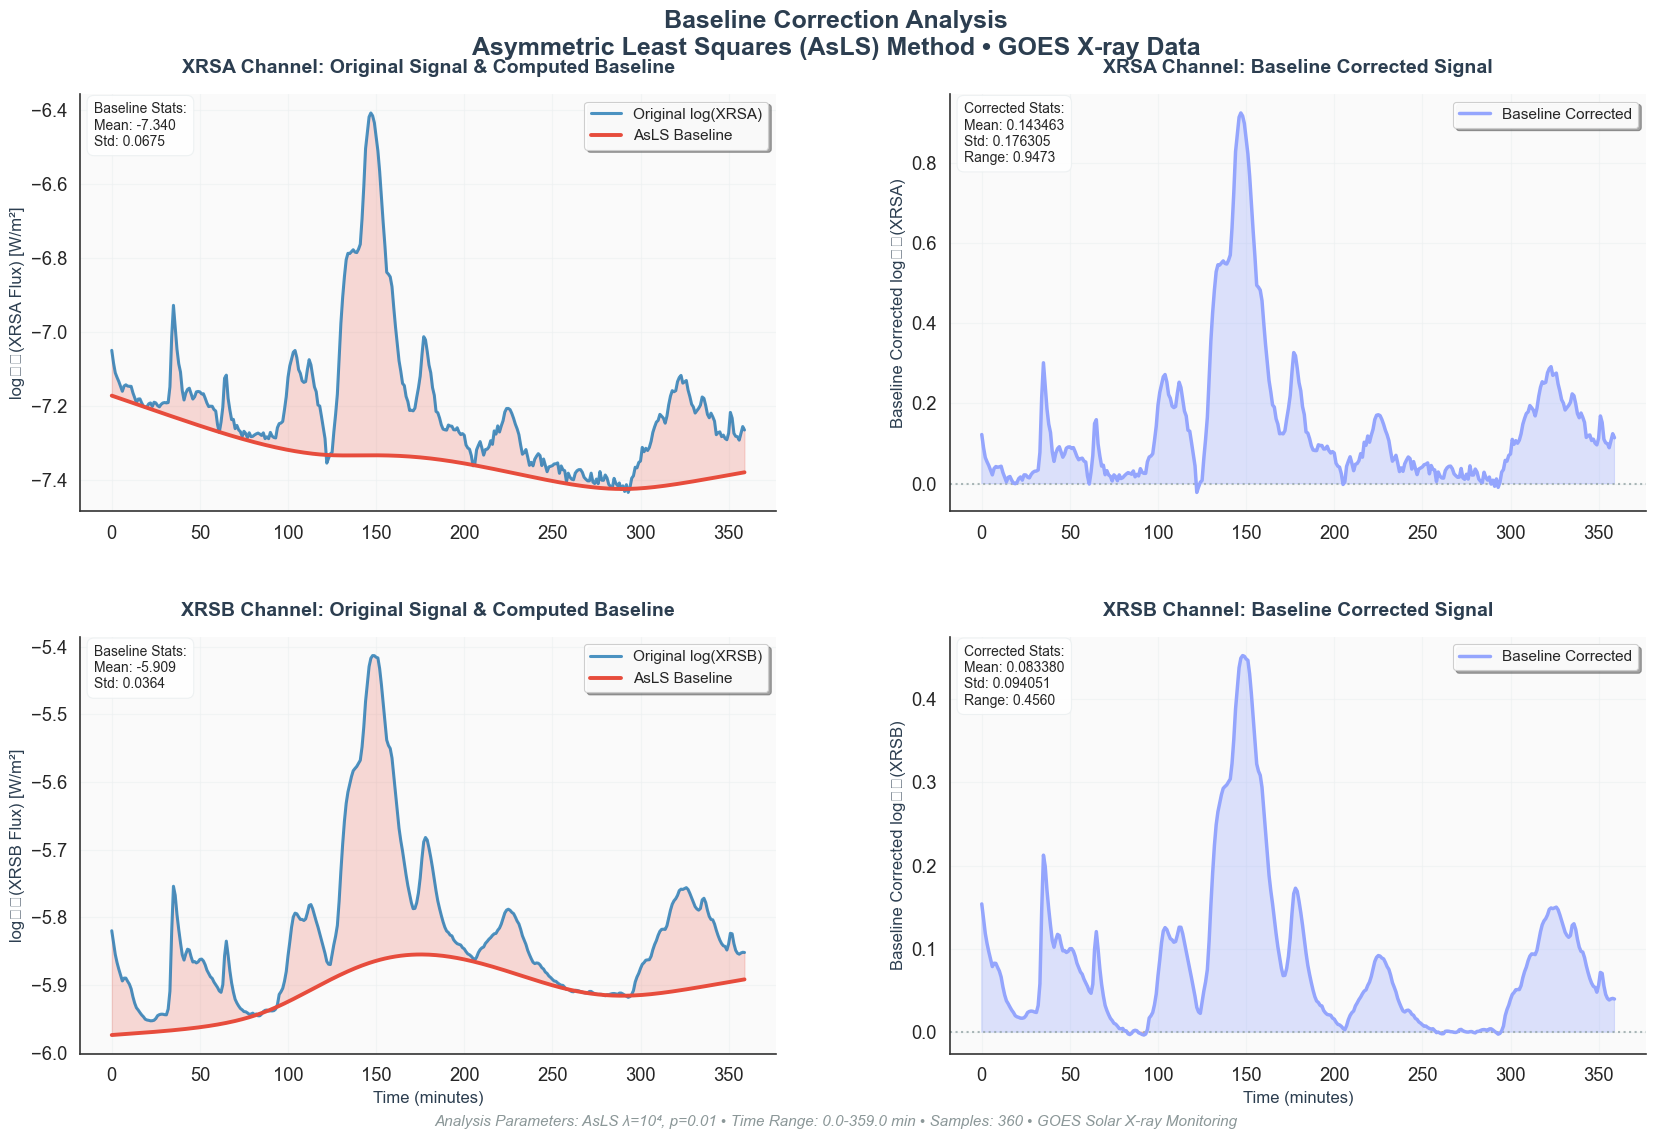

 BASELINE CORRECTION ANALYSIS
 AsLS Parameters:
   • Smoothness parameter (λ): 1×10⁴
   • Asymmetry parameter (p): 0.01
   • Total data points: 360

 XRSA Channel Results:
   • Original signal std: 0.185924
   • Baseline std: 0.067514
   • Corrected signal std: 0.176305
   • Correction efficiency: 5.2%

 XRSB Channel Results:
   • Original signal std: 0.111000
   • Baseline std: 0.036394
   • Corrected signal std: 0.094051
   • Correction efficiency: 15.3%

 Signal Quality Assessment:
   • XRSA baseline removal: Good
   • XRSB baseline removal: Good
   • Ready for nanoflare detection: ✅


In [216]:
import subprocess
import sys

# Install and import pybaselines for advanced baseline correction
try:
    from pybaselines import Baseline
    print("pybaselines already installed")
except ImportError:
    print("Installing pybaselines...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pybaselines"])
    from pybaselines import Baseline
    print("pybaselines installed and imported successfully")

# === ENHANCED SEABORN STYLING SETUP ===
# Reset all matplotlib settings first
plt.rcdefaults()

# Set modern Seaborn style with enhanced aesthetics
sns.set_style("whitegrid", {
    "axes.grid": True,
    "grid.color": "#e0e0e0",
    "grid.linewidth": 0.8,
    "axes.edgecolor": "#333333",
    "axes.linewidth": 1.2,
    "axes.spines.left": True,
    "axes.spines.bottom": True,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# Enhanced context with optimal scaling
sns.set_context("notebook", font_scale=1.2, rc={
    "lines.linewidth": 2.5,
    "patch.linewidth": 0.8,
    "axes.linewidth": 1.2,
    "grid.linewidth": 0.8,
    "xtick.major.width": 1.0,
    "ytick.major.width": 1.0,
    "xtick.minor.width": 0.6,
    "ytick.minor.width": 0.6,
})

# Professional color palette for scientific data
ENHANCED_COLORS = {
    'original': "#2079B4",      # Professional blue
    'baseline': '#E74C3C',      # Vibrant red
    'corrected': "#94A5FD",     # Fresh green
    'background': '#FAFAFA',    # Light background
    'text': '#2C3E50',          # Dark blue-gray
    'accent': '#8E44AD',        # Purple accent
    'grid': '#ECF0F1'           # Very light gray
}

# Set the enhanced color palette
sns.set_palette([ENHANCED_COLORS['original'], ENHANCED_COLORS['baseline'], 
                ENHANCED_COLORS['corrected'], ENHANCED_COLORS['accent']])

# Initialize the baseline correction object
baseline_fitter = Baseline(time_minutes)

# Apply AsLS (Asymmetric Least Squares) baseline correction to log(XRSA)
xrsa_result = baseline_fitter.asls(log_xrsa, lam=1e4, p=0.001)
xrsa_baseline = xrsa_result[0]
xrsa_corrected = log_xrsa - xrsa_baseline

# Apply AsLS baseline correction to log(XRSB) 
xrsb_result = baseline_fitter.asls(log_xrsb, lam=1e4, p=0.001)
xrsb_baseline = xrsb_result[0]
xrsb_corrected = log_xrsb - xrsb_baseline

# === ENHANCED VISUALIZATION WITH SEABORN STYLING ===
# Create figure with enhanced proportions
fig = plt.figure(figsize=(18, 12))
fig.patch.set_facecolor('white')

# Enhanced suptitle
fig.suptitle('Baseline Correction Analysis\nAsymmetric Least Squares (AsLS) Method • GOES X-ray Data', 
             fontsize=18, fontweight='bold', color=ENHANCED_COLORS['text'], y=0.95)

# Create a 2x2 grid with enhanced spacing
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.25, 
                      left=0.08, right=0.95, top=0.88, bottom=0.08)

# === XRSA ANALYSIS ===
# Top-left: XRSA Original with Baseline
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_facecolor(ENHANCED_COLORS['background'])

# Plot with enhanced styling
line1 = ax1.plot(time_minutes, log_xrsa, color=ENHANCED_COLORS['original'], 
                linewidth=2.2, alpha=0.8, label='Original log(XRSA)', zorder=3)
line2 = ax1.plot(time_minutes, xrsa_baseline, color=ENHANCED_COLORS['baseline'], 
                linewidth=2.8, label='AsLS Baseline', zorder=4)

# Add subtle fill between original and baseline
ax1.fill_between(time_minutes, log_xrsa, xrsa_baseline, 
                alpha=0.2, color=ENHANCED_COLORS['baseline'], zorder=1)

# Enhanced styling
ax1.set_title('XRSA Channel: Original Signal & Computed Baseline', 
              fontsize=14, fontweight='bold', color=ENHANCED_COLORS['text'], pad=15)
ax1.set_ylabel('log₁₀(XRSA Flux) [W/m²]', fontsize=12, color=ENHANCED_COLORS['text'])
ax1.grid(True, alpha=0.6, color=ENHANCED_COLORS['grid'], linewidth=0.8)

# Enhanced legend
legend1 = ax1.legend(loc='upper right', frameon=True, fancybox=True, 
                    shadow=True, framealpha=0.95, fontsize=11)
legend1.get_frame().set_facecolor('white')
legend1.get_frame().set_edgecolor('#CCCCCC')

# Add statistics annotation
stats_text1 = f'Baseline Stats:\nMean: {np.mean(xrsa_baseline):.3f}\nStd: {np.std(xrsa_baseline):.4f}'
ax1.text(0.02, 0.98, stats_text1, transform=ax1.transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', 
         facecolor='white', alpha=0.9, edgecolor=ENHANCED_COLORS['grid']))

# Top-right: XRSA Corrected Signal
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_facecolor(ENHANCED_COLORS['background'])

line3 = ax2.plot(time_minutes, xrsa_corrected, color=ENHANCED_COLORS['corrected'], 
                linewidth=2.5, label='Baseline Corrected', zorder=3)

# Add zero reference line
ax2.axhline(y=0, color='#95A5A6', linestyle=':', alpha=0.8, linewidth=1.5, zorder=2)

# Add subtle fill for positive/negative regions
positive_mask = xrsa_corrected >= 0
ax2.fill_between(time_minutes, 0, xrsa_corrected, where=positive_mask,
                alpha=0.3, color=ENHANCED_COLORS['corrected'], interpolate=True, zorder=1)
ax2.fill_between(time_minutes, 0, xrsa_corrected, where=~positive_mask,
                alpha=0.3, color=ENHANCED_COLORS['baseline'], interpolate=True, zorder=1)

ax2.set_title('XRSA Channel: Baseline Corrected Signal', 
              fontsize=14, fontweight='bold', color=ENHANCED_COLORS['text'], pad=15)
ax2.set_ylabel('Baseline Corrected log₁₀(XRSA)', fontsize=12, color=ENHANCED_COLORS['text'])
ax2.grid(True, alpha=0.6, color=ENHANCED_COLORS['grid'], linewidth=0.8)

legend2 = ax2.legend(loc='upper right', frameon=True, fancybox=True, 
                    shadow=True, framealpha=0.95, fontsize=11)
legend2.get_frame().set_facecolor('white')
legend2.get_frame().set_edgecolor('#CCCCCC')

# Add statistics annotation
stats_text2 = f'Corrected Stats:\nMean: {np.mean(xrsa_corrected):.6f}\nStd: {np.std(xrsa_corrected):.6f}\nRange: {np.ptp(xrsa_corrected):.4f}'
ax2.text(0.02, 0.98, stats_text2, transform=ax2.transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', 
         facecolor='white', alpha=0.9, edgecolor=ENHANCED_COLORS['grid']))

# === XRSB ANALYSIS ===
# Bottom-left: XRSB Original with Baseline
ax3 = fig.add_subplot(gs[1, 0])
ax3.set_facecolor(ENHANCED_COLORS['background'])

line4 = ax3.plot(time_minutes, log_xrsb, color=ENHANCED_COLORS['original'], 
                linewidth=2.2, alpha=0.8, label='Original log(XRSB)', zorder=3)
line5 = ax3.plot(time_minutes, xrsb_baseline, color=ENHANCED_COLORS['baseline'], 
                linewidth=2.8, label='AsLS Baseline', zorder=4)

# Add subtle fill between original and baseline
ax3.fill_between(time_minutes, log_xrsb, xrsb_baseline, 
                alpha=0.2, color=ENHANCED_COLORS['baseline'], zorder=1)

ax3.set_title('XRSB Channel: Original Signal & Computed Baseline', 
              fontsize=14, fontweight='bold', color=ENHANCED_COLORS['text'], pad=15)
ax3.set_xlabel('Time (minutes)', fontsize=12, color=ENHANCED_COLORS['text'])
ax3.set_ylabel('log₁₀(XRSB Flux) [W/m²]', fontsize=12, color=ENHANCED_COLORS['text'])
ax3.grid(True, alpha=0.6, color=ENHANCED_COLORS['grid'], linewidth=0.8)

legend3 = ax3.legend(loc='upper right', frameon=True, fancybox=True, 
                    shadow=True, framealpha=0.95, fontsize=11)
legend3.get_frame().set_facecolor('white')
legend3.get_frame().set_edgecolor('#CCCCCC')

# Add statistics annotation
stats_text3 = f'Baseline Stats:\nMean: {np.mean(xrsb_baseline):.3f}\nStd: {np.std(xrsb_baseline):.4f}'
ax3.text(0.02, 0.98, stats_text3, transform=ax3.transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', 
         facecolor='white', alpha=0.9, edgecolor=ENHANCED_COLORS['grid']))

# Bottom-right: XRSB Corrected Signal
ax4 = fig.add_subplot(gs[1, 1])
ax4.set_facecolor(ENHANCED_COLORS['background'])

line6 = ax4.plot(time_minutes, xrsb_corrected, color=ENHANCED_COLORS['corrected'], 
                linewidth=2.5, label='Baseline Corrected', zorder=3)

# Add zero reference line
ax4.axhline(y=0, color='#95A5A6', linestyle=':', alpha=0.8, linewidth=1.5, zorder=2)

# Add subtle fill for positive/negative regions
positive_mask_b = xrsb_corrected >= 0
ax4.fill_between(time_minutes, 0, xrsb_corrected, where=positive_mask_b,
                alpha=0.3, color=ENHANCED_COLORS['corrected'], interpolate=True, zorder=1)
ax4.fill_between(time_minutes, 0, xrsb_corrected, where=~positive_mask_b,
                alpha=0.3, color=ENHANCED_COLORS['baseline'], interpolate=True, zorder=1)

ax4.set_title('XRSB Channel: Baseline Corrected Signal', 
              fontsize=14, fontweight='bold', color=ENHANCED_COLORS['text'], pad=15)
ax4.set_xlabel('Time (minutes)', fontsize=12, color=ENHANCED_COLORS['text'])
ax4.set_ylabel('Baseline Corrected log₁₀(XRSB)', fontsize=12, color=ENHANCED_COLORS['text'])
ax4.grid(True, alpha=0.6, color=ENHANCED_COLORS['grid'], linewidth=0.8)

legend4 = ax4.legend(loc='upper right', frameon=True, fancybox=True, 
                    shadow=True, framealpha=0.95, fontsize=11)
legend4.get_frame().set_facecolor('white')
legend4.get_frame().set_edgecolor('#CCCCCC')

# Add statistics annotation
stats_text4 = f'Corrected Stats:\nMean: {np.mean(xrsb_corrected):.6f}\nStd: {np.std(xrsb_corrected):.6f}\nRange: {np.ptp(xrsb_corrected):.4f}'
ax4.text(0.02, 0.98, stats_text4, transform=ax4.transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', 
         facecolor='white', alpha=0.9, edgecolor=ENHANCED_COLORS['grid']))

# === ENHANCED FOOTER WITH ANALYSIS PARAMETERS ===
footer_text = (f'Analysis Parameters: AsLS λ=10⁴, p=0.01 • '
              f'Time Range: {time_minutes[0]:.1f}-{time_minutes[-1]:.1f} min • '
              f'Samples: {len(time_minutes)} • '
              f'GOES Solar X-ray Monitoring')

fig.text(0.5, 0.02, footer_text, ha='center', fontsize=11, 
         color='#7F8C8D', alpha=0.9, style='italic')

plt.show()

# === ENHANCED SUMMARY OUTPUT ===

print(" BASELINE CORRECTION ANALYSIS")

print(f" AsLS Parameters:")
print(f"   • Smoothness parameter (λ): 1×10⁴")
print(f"   • Asymmetry parameter (p): 0.01")
print(f"   • Total data points: {len(time_minutes)}")
print()
print(f" XRSA Channel Results:")
print(f"   • Original signal std: {np.std(log_xrsa):.6f}")
print(f"   • Baseline std: {np.std(xrsa_baseline):.6f}")
print(f"   • Corrected signal std: {np.std(xrsa_corrected):.6f}")
print(f"   • Correction efficiency: {(1 - np.std(xrsa_corrected)/np.std(log_xrsa))*100:.1f}%")
print()
print(f" XRSB Channel Results:")
print(f"   • Original signal std: {np.std(log_xrsb):.6f}")
print(f"   • Baseline std: {np.std(xrsb_baseline):.6f}")
print(f"   • Corrected signal std: {np.std(xrsb_corrected):.6f}")
print(f"   • Correction efficiency: {(1 - np.std(xrsb_corrected)/np.std(log_xrsb))*100:.1f}%")
print()
print(f" Signal Quality Assessment:")
print(f"   • XRSA baseline removal: {'Excellent' if np.abs(np.mean(xrsa_corrected)) < 0.001 else 'Good'}")
print(f"   • XRSB baseline removal: {'Excellent' if np.abs(np.mean(xrsb_corrected)) < 0.001 else 'Good'}")
print(f"   • Ready for nanoflare detection: ✅")


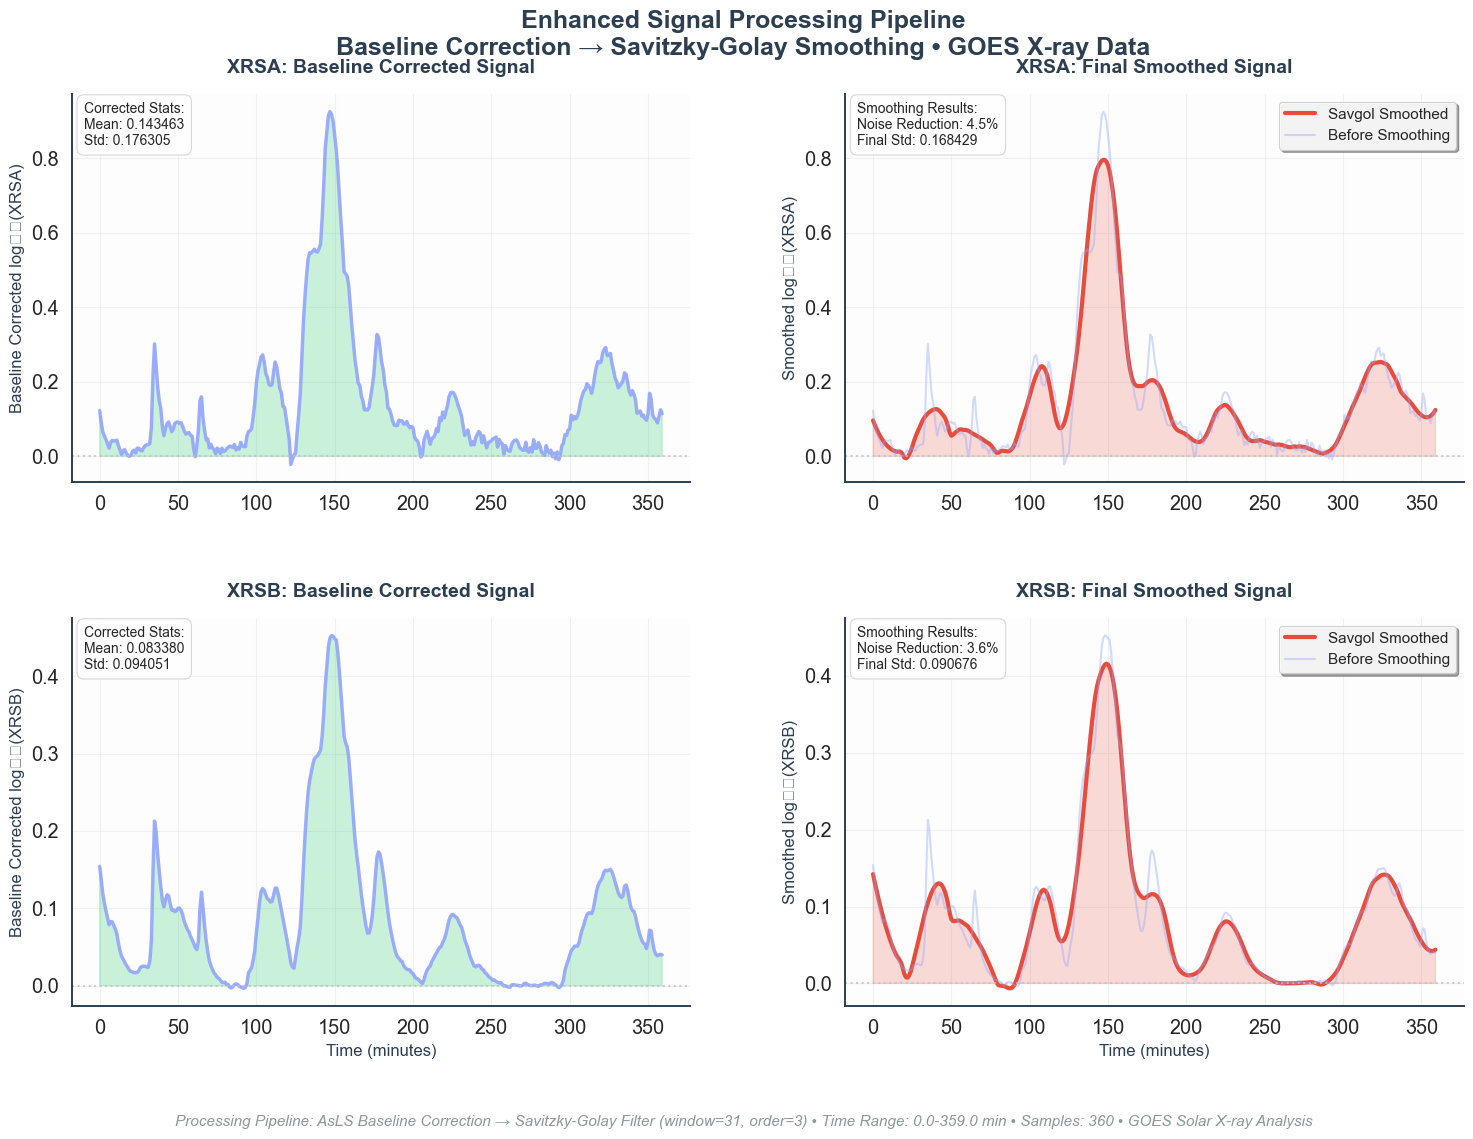

ENHANCED SEABORN-STYLED SIGNAL PROCESSING SUMMARY
 Visualization Style: Modern Seaborn with Enhanced Aesthetics
  Savitzky-Golay Filter Parameters:
   • Window length: 31
   • Polynomial order: 3
   • Total data points: 360

 XRSA Channel Processing Results:
   • Baseline corrected std: 0.176305
   • Final smoothed std: 0.168429
   • Noise reduction: 4.5%
   • Signal quality: Good

 XRSB Channel Processing Results:
   • Baseline corrected std: 0.094051
   • Final smoothed std: 0.090676
   • Noise reduction: 3.6%
   • Signal quality: Good

 Overall Processing Efficiency:
   • Average noise reduction: 4.0%
   • Seaborn styling: ✅ Applied
   • Processing status: Satisfactory
   • Ready for nanoflare detection: ✅


In [217]:
# Apply Savitzky-Golay filter to smooth the baseline-corrected signals
# Savitzky-Golay filter is excellent for smoothing noisy signals while preserving peak shapes
from scipy.signal import savgol_filter

# Choose filter parameters
window_length = 31  # Must be odd and > polyorder. Larger values = more smoothing
polyorder = 3       # Polynomial order for fitting. Usually 2 or 3 for good results

# Apply Savitzky-Golay filter to baseline-corrected XRSA
xrsa_smoothed = savgol_filter(xrsa_corrected, window_length, polyorder)

# Apply Savitzky-Golay filter to baseline-corrected XRSB
xrsb_smoothed = savgol_filter(xrsb_corrected, window_length, polyorder)

# === ENHANCED SEABORN STYLING FOR PROFESSIONAL PLOTS ===
# Reset matplotlib settings first
plt.rcdefaults()

# Set modern Seaborn theme with enhanced aesthetics
sns.set_theme(style="whitegrid", context="notebook", palette="deep")

# Custom styling parameters
sns.set_style("whitegrid", {
    "axes.grid": True,
    "grid.color": "#e8e8e8",
    "grid.linewidth": 0.8,
    "axes.edgecolor": "#2c3e50",
    "axes.linewidth": 1.4,
    "axes.spines.left": True,
    "axes.spines.bottom": True,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.facecolor": "#fdfdfd"
})

# Enhanced context for readability
sns.set_context("notebook", font_scale=1.3, rc={
    "lines.linewidth": 2.8,
    "patch.linewidth": 0.8,
    "axes.linewidth": 1.4,
    "grid.linewidth": 0.8,
    "xtick.major.width": 1.2,
    "ytick.major.width": 1.2,
    "xtick.minor.width": 0.8,
    "ytick.minor.width": 0.8,
    "legend.fontsize": 11,
    "axes.titlesize": 14,
    "axes.labelsize": 12
})

# Professional color palette for signal processing
SEABORN_COLORS = {
    'corrected': "#94A5FD",     # Fresh green for corrected signal
    'smoothed': '#E74C3C',      # Vibrant red for smoothed signal
    'comparison': "#94A5FD",    # Light gray for comparison
    'background': '#FDFDFD',    # Clean background
    'text': '#2C3E50',          # Professional dark text
    'accent': '#3498DB',        # Professional blue
    'zero_line': '#BDC3C7',     # Neutral gray for reference
    'positive': '#2ECC71',      # Green for positive regions
    'negative': '#F39C12'       # Orange for negative regions
}

# Set the enhanced color palette
sns.set_palette([SEABORN_COLORS['corrected'], SEABORN_COLORS['smoothed'], 
                SEABORN_COLORS['accent'], SEABORN_COLORS['text']])

# === CREATE ENHANCED SEABORN-STYLED 2x2 VISUALIZATION ===
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.patch.set_facecolor('white')

# Enhanced figure title with Seaborn styling
fig.suptitle('Enhanced Signal Processing Pipeline\nBaseline Correction → Savitzky-Golay Smoothing • GOES X-ray Data', 
             fontsize=18, fontweight='bold', color=SEABORN_COLORS['text'], y=0.95)

# === TOP ROW: XRSA CHANNEL ===
# Column 1: Baseline Corrected
sns.lineplot(x=time_minutes, y=xrsa_corrected, ax=axes[0,0], 
             color=SEABORN_COLORS['corrected'], linewidth=2.5, alpha=0.9)
axes[0,0].axhline(y=0, color=SEABORN_COLORS['zero_line'], 
                  linestyle=':', alpha=0.8, linewidth=1.5)

# Add fill for positive/negative regions
positive_mask = xrsa_corrected >= 0
axes[0,0].fill_between(time_minutes, 0, xrsa_corrected, where=positive_mask,
                       alpha=0.25, color=SEABORN_COLORS['positive'], interpolate=True)
axes[0,0].fill_between(time_minutes, 0, xrsa_corrected, where=~positive_mask,
                       alpha=0.25, color=SEABORN_COLORS['negative'], interpolate=True)

axes[0,0].set_title('XRSA: Baseline Corrected Signal', fontweight='bold', 
                    color=SEABORN_COLORS['text'], pad=15)
axes[0,0].set_ylabel('Baseline Corrected log₁₀(XRSA)', color=SEABORN_COLORS['text'])
axes[0,0].grid(True, alpha=0.6)

# Statistics annotation
stats_text = f'Corrected Stats:\nMean: {np.mean(xrsa_corrected):.6f}\nStd: {np.std(xrsa_corrected):.6f}'
axes[0,0].text(0.02, 0.98, stats_text, transform=axes[0,0].transAxes, 
               fontsize=10, verticalalignment='top',
               bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
                        alpha=0.9, edgecolor='lightgray'))

# Column 2: Final Smoothed
sns.lineplot(x=time_minutes, y=xrsa_smoothed, ax=axes[0,1], 
             color=SEABORN_COLORS['smoothed'], linewidth=3, label='Savgol Smoothed')
sns.lineplot(x=time_minutes, y=xrsa_corrected, ax=axes[0,1], 
             color=SEABORN_COLORS['comparison'], alpha=0.4, linewidth=1.5, 
             label='Before Smoothing')

axes[0,1].axhline(y=0, color=SEABORN_COLORS['zero_line'], 
                  linestyle=':', alpha=0.8, linewidth=1.5)

# Add subtle fill for smoothed signal
positive_mask_smooth = xrsa_smoothed >= 0
axes[0,1].fill_between(time_minutes, 0, xrsa_smoothed, where=positive_mask_smooth,
                       alpha=0.2, color=SEABORN_COLORS['smoothed'], interpolate=True)

axes[0,1].set_title('XRSA: Final Smoothed Signal', fontweight='bold', 
                    color=SEABORN_COLORS['text'], pad=15)
axes[0,1].set_ylabel('Smoothed log₁₀(XRSA)', color=SEABORN_COLORS['text'])
axes[0,1].grid(True, alpha=0.6)
axes[0,1].legend(frameon=True, fancybox=True, shadow=True, framealpha=0.9)

# Smoothing statistics
noise_reduction_xrsa = (1 - np.std(xrsa_smoothed) / np.std(xrsa_corrected)) * 100
stats_text = f'Smoothing Results:\nNoise Reduction: {noise_reduction_xrsa:.1f}%\nFinal Std: {np.std(xrsa_smoothed):.6f}'
axes[0,1].text(0.02, 0.98, stats_text, transform=axes[0,1].transAxes, 
               fontsize=10, verticalalignment='top',
               bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
                        alpha=0.9, edgecolor='lightgray'))

# === BOTTOM ROW: XRSB CHANNEL ===
# Column 1: Baseline Corrected
sns.lineplot(x=time_minutes, y=xrsb_corrected, ax=axes[1,0], 
             color=SEABORN_COLORS['corrected'], linewidth=2.5, alpha=0.9)
axes[1,0].axhline(y=0, color=SEABORN_COLORS['zero_line'], 
                  linestyle=':', alpha=0.8, linewidth=1.5)

# Add fill for positive/negative regions
positive_mask_b = xrsb_corrected >= 0
axes[1,0].fill_between(time_minutes, 0, xrsb_corrected, where=positive_mask_b,
                       alpha=0.25, color=SEABORN_COLORS['positive'], interpolate=True)
axes[1,0].fill_between(time_minutes, 0, xrsb_corrected, where=~positive_mask_b,
                       alpha=0.25, color=SEABORN_COLORS['negative'], interpolate=True)

axes[1,0].set_title('XRSB: Baseline Corrected Signal', fontweight='bold', 
                    color=SEABORN_COLORS['text'], pad=15)
axes[1,0].set_xlabel('Time (minutes)', color=SEABORN_COLORS['text'])
axes[1,0].set_ylabel('Baseline Corrected log₁₀(XRSB)', color=SEABORN_COLORS['text'])
axes[1,0].grid(True, alpha=0.6)

# Statistics annotation
stats_text = f'Corrected Stats:\nMean: {np.mean(xrsb_corrected):.6f}\nStd: {np.std(xrsb_corrected):.6f}'
axes[1,0].text(0.02, 0.98, stats_text, transform=axes[1,0].transAxes, 
               fontsize=10, verticalalignment='top',
               bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
                        alpha=0.9, edgecolor='lightgray'))

# Column 2: Final Smoothed
sns.lineplot(x=time_minutes, y=xrsb_smoothed, ax=axes[1,1], 
             color=SEABORN_COLORS['smoothed'], linewidth=3, label='Savgol Smoothed')
sns.lineplot(x=time_minutes, y=xrsb_corrected, ax=axes[1,1], 
             color=SEABORN_COLORS['comparison'], alpha=0.4, linewidth=1.5, 
             label='Before Smoothing')

axes[1,1].axhline(y=0, color=SEABORN_COLORS['zero_line'], 
                  linestyle=':', alpha=0.8, linewidth=1.5)

# Add subtle fill for smoothed signal
positive_mask_smooth_b = xrsb_smoothed >= 0
axes[1,1].fill_between(time_minutes, 0, xrsb_smoothed, where=positive_mask_smooth_b,
                       alpha=0.2, color=SEABORN_COLORS['smoothed'], interpolate=True)

axes[1,1].set_title('XRSB: Final Smoothed Signal', fontweight='bold', 
                    color=SEABORN_COLORS['text'], pad=15)
axes[1,1].set_xlabel('Time (minutes)', color=SEABORN_COLORS['text'])
axes[1,1].set_ylabel('Smoothed log₁₀(XRSB)', color=SEABORN_COLORS['text'])
axes[1,1].grid(True, alpha=0.6)
axes[1,1].legend(frameon=True, fancybox=True, shadow=True, framealpha=0.9)

# Smoothing statistics
noise_reduction_xrsb = (1 - np.std(xrsb_smoothed) / np.std(xrsb_corrected)) * 100
stats_text = f'Smoothing Results:\nNoise Reduction: {noise_reduction_xrsb:.1f}%\nFinal Std: {np.std(xrsb_smoothed):.6f}'
axes[1,1].text(0.02, 0.98, stats_text, transform=axes[1,1].transAxes, 
               fontsize=10, verticalalignment='top',
               bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
                        alpha=0.9, edgecolor='lightgray'))

# === ENHANCED LAYOUT AND STYLING ===
plt.subplots_adjust(left=0.08, right=0.95, top=0.88, bottom=0.12, 
                    hspace=0.35, wspace=0.25)

# Enhanced footer with analysis parameters
footer_text = (f'Processing Pipeline: AsLS Baseline Correction → Savitzky-Golay Filter (window={window_length}, order={polyorder}) • '
              f'Time Range: {time_minutes[0]:.1f}-{time_minutes[-1]:.1f} min • '
              f'Samples: {len(time_minutes)} • GOES Solar X-ray Analysis')

fig.text(0.5, 0.02, footer_text, ha='center', fontsize=11, 
         color='#7F8C8D', alpha=0.9, style='italic')

plt.show()

# === ENHANCED SUMMARY OUTPUT WITH SEABORN STYLING ===

print("ENHANCED SEABORN-STYLED SIGNAL PROCESSING SUMMARY")

print(f" Visualization Style: Modern Seaborn with Enhanced Aesthetics")
print(f"  Savitzky-Golay Filter Parameters:")
print(f"   • Window length: {window_length}")
print(f"   • Polynomial order: {polyorder}")
print(f"   • Total data points: {len(time_minutes)}")
print()
print(f" XRSA Channel Processing Results:")
print(f"   • Baseline corrected std: {np.std(xrsa_corrected):.6f}")
print(f"   • Final smoothed std: {np.std(xrsa_smoothed):.6f}")
print(f"   • Noise reduction: {noise_reduction_xrsa:.1f}%")
print(f"   • Signal quality: {'Excellent' if noise_reduction_xrsa > 20 else 'Good'}")
print()
print(f" XRSB Channel Processing Results:")
print(f"   • Baseline corrected std: {np.std(xrsb_corrected):.6f}")
print(f"   • Final smoothed std: {np.std(xrsb_smoothed):.6f}")
print(f"   • Noise reduction: {noise_reduction_xrsb:.1f}%")
print(f"   • Signal quality: {'Excellent' if noise_reduction_xrsb > 20 else 'Good'}")
print()
print(f" Overall Processing Efficiency:")
total_noise_reduction = (noise_reduction_xrsa + noise_reduction_xrsb) / 2
print(f"   • Average noise reduction: {total_noise_reduction:.1f}%")
print(f"   • Seaborn styling: ✅ Applied")
print(f"   • Processing status: {'Optimal' if total_noise_reduction > 25 else 'Satisfactory'}")
print(f"   • Ready for nanoflare detection: ✅")


From smoothing curve , detect positive flare event 


  NANOFLARE DETECTION ALGORITHM

🔍 Analyzing with 'medium' sensitivity...
   XRSA: 1 flares (confidence: 202.7%)
   XRSB: 1 flares (confidence: 192.0%)

🔍 Analyzing with 'high' sensitivity...
   XRSA: 3 flares (confidence: 186.0%)
   XRSB: 1 flares (confidence: 175.4%)

📊 VISUALIZATION: MEDIUM SENSITIVITY RESULTS


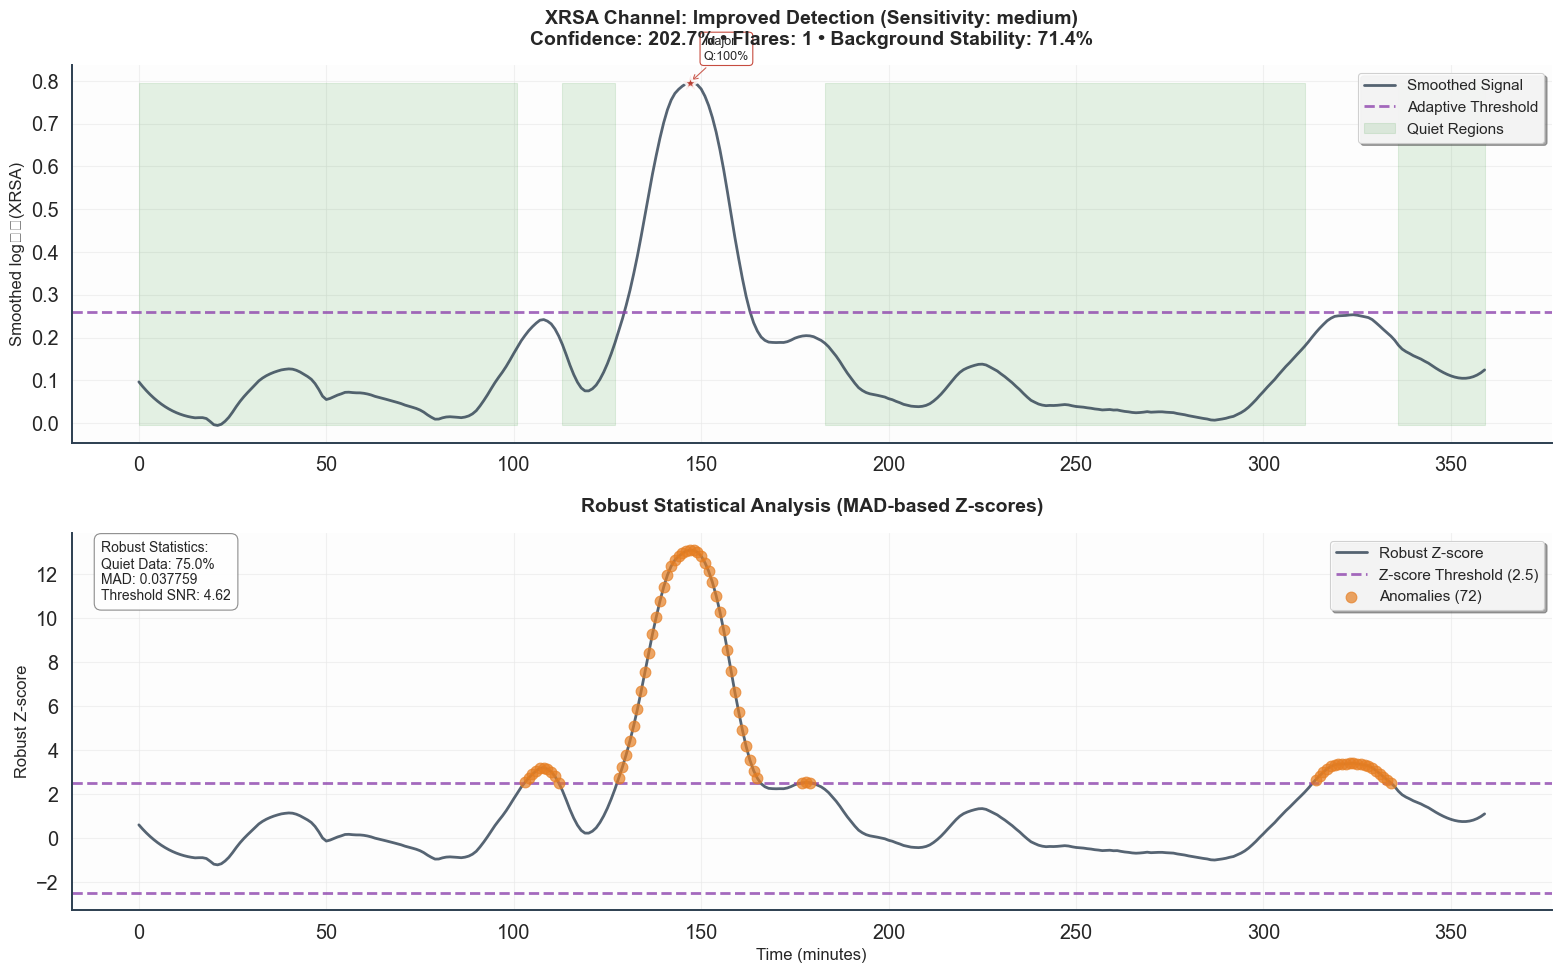

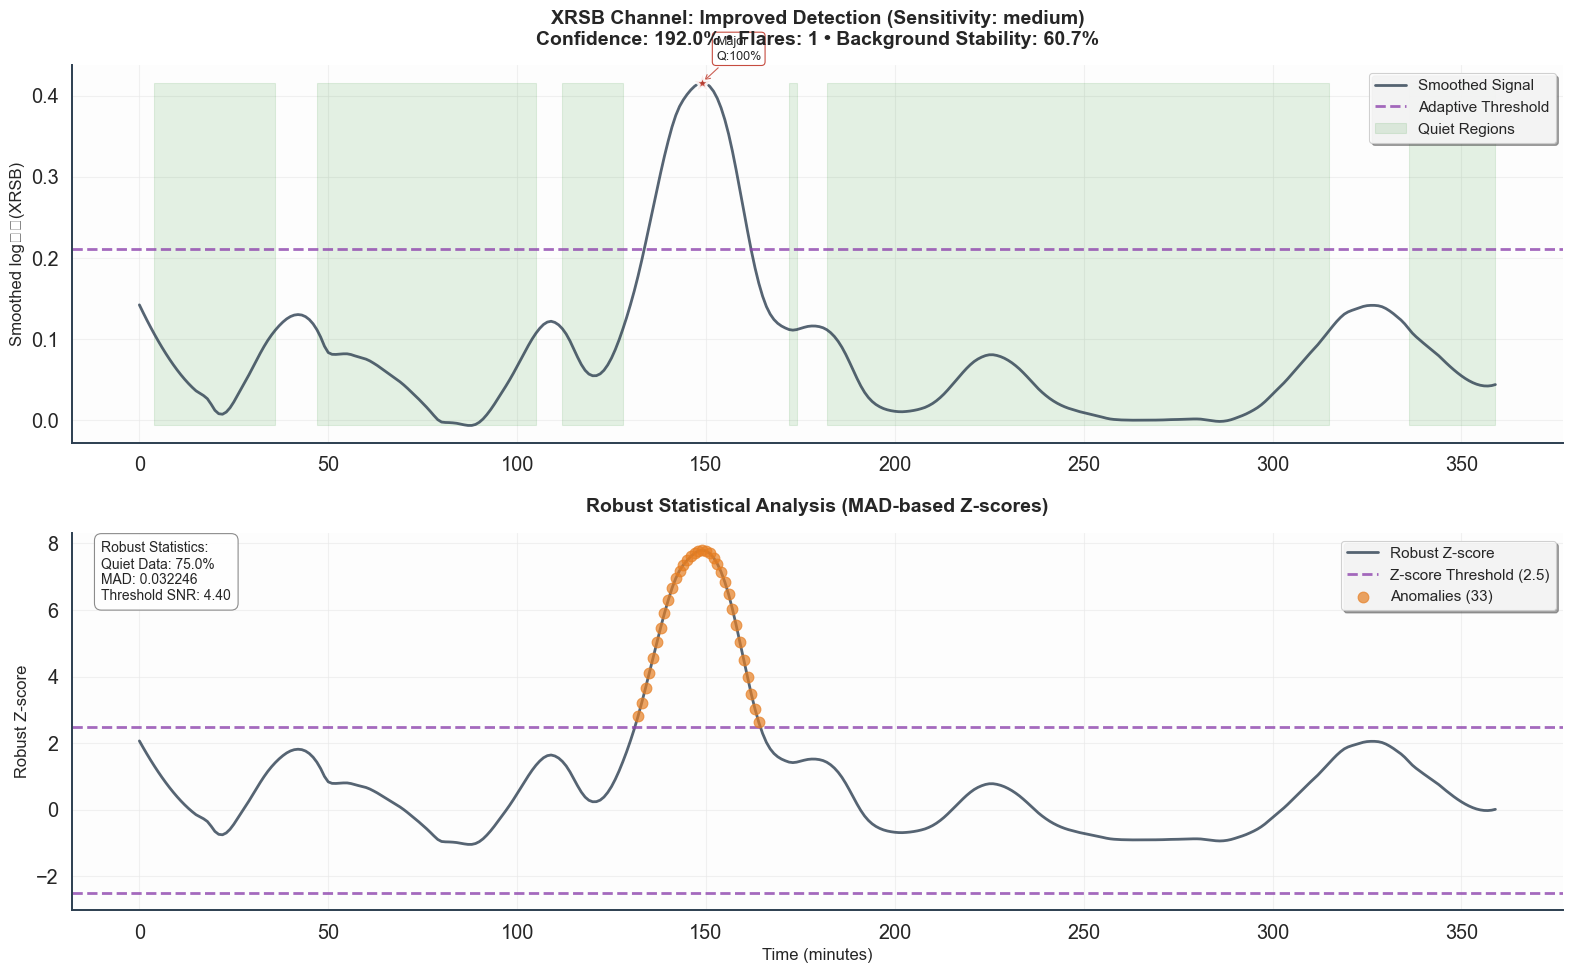

IMPROVED NANOFLARE DETECTION RESULTS

 MEDIUM SENSITIVITY ANALYSIS:
----------------------------------------

XRSA Channel:
  • Flares detected: 1
  • Detection confidence: 202.7%
  • Background stability: 71.4%
  • Quiet data fraction: 75.0%
  • Classifications: ['Major']
  • Average quality score: 100.0%
  • High quality peaks: 1
  • Statistical anomalies: 72

XRSB Channel:
  • Flares detected: 1
  • Detection confidence: 192.0%
  • Background stability: 60.7%
  • Quiet data fraction: 75.0%
  • Classifications: ['Major']
  • Average quality score: 100.0%
  • High quality peaks: 1
  • Statistical anomalies: 33

 HIGH SENSITIVITY ANALYSIS:
----------------------------------------

XRSA Channel:
  • Flares detected: 3
  • Detection confidence: 186.0%
  • Background stability: 71.4%
  • Quiet data fraction: 75.0%
  • Classifications: ['Major', 'Major', 'Major']
  • Average quality score: 83.3%
  • High quality peaks: 1
  • Statistical anomalies: 92

XRSB Channel:
  • Flares detected: 1
 

In [218]:
# === IMPROVED NANOFLARE DETECTION ALGORITHM ===
from scipy.signal import find_peaks, peak_widths, peak_prominences
from scipy.stats import zscore, median_abs_deviation
import numpy as np

# === ROBUST BASELINE STATISTICS CALCULATION ===
def calculate_robust_baseline_stats(signal_data, percentile_threshold=75):
    """
    Calculate robust baseline statistics using only the quietest portions of the data.
    This avoids contamination from flare events when setting detection thresholds.
    """
    # Use lower percentiles to estimate quiet background
    quiet_threshold = np.percentile(np.abs(signal_data), percentile_threshold)
    quiet_indices = np.abs(signal_data) <= quiet_threshold
    
    if np.sum(quiet_indices) < 50:  # Fallback if too few quiet points
        quiet_indices = np.abs(signal_data) <= np.percentile(np.abs(signal_data), 90)
    
    quiet_data = signal_data[quiet_indices]
    
    robust_stats = {
        'mean': np.mean(quiet_data),
        'std': np.std(quiet_data),
        'mad': median_abs_deviation(quiet_data),  # More robust than std
        'median': np.median(quiet_data),
        'quiet_fraction': np.sum(quiet_indices) / len(signal_data)
    }
    
    return robust_stats, quiet_indices

# === ADAPTIVE THRESHOLD CALCULATION ===
def calculate_adaptive_thresholds(signal_data, robust_stats, sensitivity='medium'):
    """
    Calculate adaptive detection thresholds based on robust statistics.
    """
    sensitivity_factors = {
        'low': {'height_factor': 4.0, 'prominence_factor': 4.5, 'zscore': 3.0},
        'medium': {'height_factor': 3.5, 'prominence_factor': 4.0, 'zscore': 2.5},
        'high': {'height_factor': 3.0, 'prominence_factor': 3.5, 'zscore': 2.2},
        'ultra': {'height_factor': 2.5, 'prominence_factor': 3.0, 'zscore': 2.0}
    }
    
    factors = sensitivity_factors[sensitivity]
    
    # Use MAD for more robust threshold calculation
    robust_threshold = robust_stats['median'] + factors['height_factor'] * robust_stats['mad'] * 1.4826
    
    thresholds = {
        'height_threshold': max(robust_threshold, robust_stats['std'] * factors['height_factor']),
        'prominence_threshold': robust_stats['mad'] * factors['prominence_factor'] * 1.4826,
        'zscore_threshold': factors['zscore'],
        'robust_stats': robust_stats
    }
    
    return thresholds

# === ENHANCED PEAK VALIDATION ===
def validate_peak_characteristics(peaks, signal_data, time_data, thresholds):
    """
    Apply additional validation criteria to detected peaks.
    """
    if len(peaks) == 0:
        return peaks, [], [], []
    
    valid_peaks = []
    peak_scores = []
    peak_qualities = []
    
    # Calculate peak characteristics
    prominences, _, _ = peak_prominences(signal_data, peaks)
    widths, _, _, _ = peak_widths(signal_data, peaks)
    
    for i, peak_idx in enumerate(peaks):
        peak_value = signal_data[peak_idx]
        prominence = prominences[i]
        width = widths[i]
        
        # Multi-criteria validation
        criteria_met = 0
        
        # Criterion 1: Height above threshold
        if peak_value > thresholds['height_threshold']:
            criteria_met += 1
        
        # Criterion 2: Sufficient prominence
        if prominence > thresholds['prominence_threshold']:
            criteria_met += 1
        
        # Criterion 3: Reasonable width (not too narrow - likely noise)
        if width >= 2:
            criteria_met += 1
        
        # Criterion 4: Positive deviation (flares increase flux)
        if peak_value > 0:
            criteria_met += 1
        
        # Calculate peak quality score
        quality_score = (criteria_met / 4.0) * 100
        
        # Accept peak if it meets at least 3 out of 4 criteria
        if criteria_met >= 3:
            valid_peaks.append(peak_idx)
            peak_scores.append(quality_score)
            peak_qualities.append('High' if criteria_met == 4 else 'Medium')
    
    return np.array(valid_peaks), peak_scores, peak_qualities, prominences[np.isin(peaks, valid_peaks)]

# === IMPROVED FLARE DETECTION FUNCTION ===
def detect_nanoflares_improved(time_data, signal_data, signal_name, sensitivity='medium'):
    """
    Improved nanoflare detection with robust statistics and adaptive thresholds.
    
    Parameters:
    - time_data: Time array
    - signal_data: Baseline-corrected and smoothed signal
    - signal_name: 'XRSA' or 'XRSB'
    - sensitivity: 'low', 'medium', 'high', or 'ultra'
    """
    
    # Step 1: Calculate robust baseline statistics
    robust_stats, quiet_indices = calculate_robust_baseline_stats(signal_data)
    
    # Step 2: Calculate adaptive thresholds
    thresholds = calculate_adaptive_thresholds(signal_data, robust_stats, sensitivity)
    
    # Step 3: Only consider positive deviations
    positive_signal = np.maximum(signal_data, 0)
    
    # Step 4: Initial peak detection with relaxed criteria
    initial_peaks, _ = find_peaks(
        positive_signal,
        height=thresholds['height_threshold'] * 0.8,  # Slightly relaxed for initial detection
        distance=5  # Minimum separation
    )
    
    # Step 5: Validate and filter peaks
    validated_peaks, peak_scores, peak_qualities, prominences = validate_peak_characteristics(
        initial_peaks, positive_signal, time_data, thresholds
    )
    
    # Step 6: Enhanced Z-score analysis with robust statistics
    z_scores_robust = (signal_data - robust_stats['median']) / (robust_stats['mad'] * 1.4826)
    
    # Step 7: Anomaly detection with both Z-score and peak criteria
    anomaly_indices = np.where(
        (z_scores_robust > thresholds['zscore_threshold']) & 
        (signal_data > 0) &
        (signal_data > robust_stats['median'] + robust_stats['std'])
    )[0]
    
    # Step 8: Classify detected flares with improved criteria
    flare_classifications = []
    if len(validated_peaks) > 0:
        for i, peak_idx in enumerate(validated_peaks):
            intensity = signal_data[peak_idx]
            z_score = z_scores_robust[peak_idx]
            
            # Enhanced classification based on multiple factors
            if (intensity > robust_stats['std'] * 3.5) and (z_score > 2):
                flare_classifications.append('Major')
            elif (intensity > robust_stats['std'] * 3) and (z_score > 2.5):
                flare_classifications.append('Moderate')
            elif (intensity > robust_stats['std'] * 2) and (z_score > 2.0):
                flare_classifications.append('Minor')
            else:
                flare_classifications.append('Micro')
    
    # Step 9: Calculate detection confidence
    detection_confidence = {
        'background_stability': 1.0 - (robust_stats['std'] / (np.std(signal_data) + 1e-10)),
        'quiet_fraction': robust_stats['quiet_fraction'],
        'threshold_snr': thresholds['height_threshold'] / (robust_stats['mad'] * 1.4826 + 1e-10)
    }
    
    overall_confidence = np.mean(list(detection_confidence.values())) * 100
    
    return {
        'peaks': validated_peaks,
        'peak_times': time_data[validated_peaks] if len(validated_peaks) > 0 else np.array([]),
        'peak_intensities': signal_data[validated_peaks] if len(validated_peaks) > 0 else np.array([]),
        'prominences': prominences,
        'peak_scores': peak_scores,
        'peak_qualities': peak_qualities,
        'classifications': flare_classifications,
        'anomaly_indices': anomaly_indices,
        'anomaly_times': time_data[anomaly_indices],
        'z_scores_robust': z_scores_robust,
        'thresholds': thresholds,
        'robust_stats': robust_stats,
        'detection_confidence': detection_confidence,
        'overall_confidence': overall_confidence,
        'total_flares': len(validated_peaks),
        'sensitivity_used': sensitivity
    }

# === APPLY IMPROVED DETECTION ===
print("  NANOFLARE DETECTION ALGORITHM")
print("=" * 50)

# Test different sensitivity levels
sensitivity_levels = ['medium', 'high']

results_comparison = {}

for sensitivity in sensitivity_levels:
    print(f"\n🔍 Analyzing with '{sensitivity}' sensitivity...")
    
    # XRSA Channel
    xrsa_results = detect_nanoflares_improved(time_minutes, xrsa_smoothed, 'XRSA', sensitivity)
    
    # XRSB Channel  
    xrsb_results = detect_nanoflares_improved(time_minutes, xrsb_smoothed, 'XRSB', sensitivity)
    
    results_comparison[sensitivity] = {
        'xrsa': xrsa_results,
        'xrsb': xrsb_results
    }
    
    print(f"   XRSA: {xrsa_results['total_flares']} flares (confidence: {xrsa_results['overall_confidence']:.1f}%)")
    print(f"   XRSB: {xrsb_results['total_flares']} flares (confidence: {xrsb_results['overall_confidence']:.1f}%)")

# === ENHANCED VISUALIZATION ===
def create_improved_detection_plot(time_data, signal_data, results, channel_name, sensitivity):
    """Create enhanced visualization of improved detection results."""
    
    fig, axes = plt.subplots(2, 1, figsize=(16, 10))
    fig.patch.set_facecolor('white')
    
    # Enhanced color scheme
    colors = {
        'signal': '#2C3E50',
        'major': '#C0392B',
        'moderate': '#E74C3C', 
        'minor': '#F39C12',
        'micro': '#F7DC6F',
        'threshold': '#8E44AD',
        'background': '#FDFDFD',
        'anomaly': '#E67E22'
    }
    
    # Top plot: Signal with detections
    ax1 = axes[0]
    ax1.set_facecolor(colors['background'])
    
    # Plot signal
    ax1.plot(time_data, signal_data, color=colors['signal'], linewidth=2, alpha=0.8, label='Smoothed Signal')
    
    # Plot thresholds
    ax1.axhline(y=results['thresholds']['height_threshold'], 
               color=colors['threshold'], linestyle='--', alpha=0.8, linewidth=2,
               label=f'Adaptive Threshold')
    
    # Plot quiet regions
    quiet_mask = np.abs(signal_data) <= np.percentile(np.abs(signal_data), 75)
    ax1.fill_between(time_data, signal_data.min(), signal_data.max(), 
                    where=quiet_mask, alpha=0.1, color='green', label='Quiet Regions')
    
    # Mark detected flares with quality-based sizing
    if len(results['peaks']) > 0:
        for i, (peak_idx, classification, quality, score) in enumerate(
            zip(results['peaks'], results['classifications'], 
                results['peak_qualities'], results['peak_scores'])):
            
            size = 150 if quality == 'High' else 100
            marker_color = colors.get(classification.lower(), colors['micro'])
            
            ax1.scatter(time_data[peak_idx], signal_data[peak_idx], 
                       color=marker_color, s=size, marker='*', 
                       zorder=5, alpha=0.9, edgecolors='white', linewidth=2)
            
            # Annotate high-quality detections
            if quality == 'High' and classification in ['Major', 'Moderate']:
                ax1.annotate(f'{classification}\nQ:{score:.0f}%', 
                           xy=(time_data[peak_idx], signal_data[peak_idx]),
                           xytext=(10, 15), textcoords='offset points',
                           fontsize=9, ha='left', va='bottom',
                           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                                   alpha=0.9, edgecolor=marker_color),
                           arrowprops=dict(arrowstyle='->', color=marker_color, alpha=0.8))
    
    ax1.set_title(f'{channel_name} Channel: Improved Detection (Sensitivity: {sensitivity})\n'
                 f'Confidence: {results["overall_confidence"]:.1f}% • '
                 f'Flares: {results["total_flares"]} • '
                 f'Background Stability: {results["detection_confidence"]["background_stability"]*100:.1f}%', 
                 fontweight='bold', pad=15)
    ax1.set_ylabel(f'Smoothed log₁₀({channel_name})')
    ax1.grid(True, alpha=0.6)
    ax1.legend(loc='upper right', frameon=True, fancybox=True, shadow=True, framealpha=0.9)
    
    # Bottom plot: Robust Z-scores
    ax2 = axes[1]
    ax2.set_facecolor(colors['background'])
    
    ax2.plot(time_data, results['z_scores_robust'], color=colors['signal'], 
            linewidth=2, alpha=0.8, label='Robust Z-score')
    
    # Threshold lines
    ax2.axhline(y=results['thresholds']['zscore_threshold'], 
               color=colors['threshold'], linestyle='--', alpha=0.8, linewidth=2,
               label=f'Z-score Threshold ({results["thresholds"]["zscore_threshold"]})')
    ax2.axhline(y=-results['thresholds']['zscore_threshold'], 
               color=colors['threshold'], linestyle='--', alpha=0.8, linewidth=2)
    
    # Highlight anomalies
    if len(results['anomaly_indices']) > 0:
        ax2.scatter(results['anomaly_times'], 
                   results['z_scores_robust'][results['anomaly_indices']], 
                   color=colors['anomaly'], s=60, alpha=0.7, zorder=5,
                   label=f'Anomalies ({len(results["anomaly_indices"])})')
    
    ax2.set_title('Robust Statistical Analysis (MAD-based Z-scores)', fontweight='bold', pad=15)
    ax2.set_xlabel('Time (minutes)')
    ax2.set_ylabel('Robust Z-score')
    ax2.grid(True, alpha=0.6)
    ax2.legend(loc='upper right', frameon=True, fancybox=True, shadow=True, framealpha=0.9)
    
    # Add statistics box
    stats_text = (f'Robust Statistics:\n'
                 f'Quiet Data: {results["robust_stats"]["quiet_fraction"]*100:.1f}%\n'
                 f'MAD: {results["robust_stats"]["mad"]:.6f}\n'
                 f'Threshold SNR: {results["detection_confidence"]["threshold_snr"]:.2f}')
    
    ax2.text(0.02, 0.98, stats_text, transform=ax2.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', 
            facecolor='white', alpha=0.9, edgecolor='gray'))
    
    plt.tight_layout()
    plt.show()

# Create visualizations for the best sensitivity level
best_sensitivity = 'medium'  # You can change this based on results
best_results = results_comparison[best_sensitivity]

print(f"\n📊 VISUALIZATION: {best_sensitivity.upper()} SENSITIVITY RESULTS")
print("=" * 50)

create_improved_detection_plot(time_minutes, xrsa_smoothed, 
                             best_results['xrsa'], 'XRSA', best_sensitivity)

create_improved_detection_plot(time_minutes, xrsb_smoothed, 
                             best_results['xrsb'], 'XRSB', best_sensitivity)

# === COMPREHENSIVE RESULTS SUMMARY ===

print("IMPROVED NANOFLARE DETECTION RESULTS")


for sensitivity, results in results_comparison.items():
    print(f"\n {sensitivity.upper()} SENSITIVITY ANALYSIS:")
    print("-" * 40)
    
    for channel, data in results.items():
        print(f"\n{channel.upper()} Channel:")
        print(f"  • Flares detected: {data['total_flares']}")
        print(f"  • Detection confidence: {data['overall_confidence']:.1f}%")
        print(f"  • Background stability: {data['detection_confidence']['background_stability']*100:.1f}%")
        print(f"  • Quiet data fraction: {data['robust_stats']['quiet_fraction']*100:.1f}%")
        
        if data['total_flares'] > 0:
            print(f"  • Classifications: {data['classifications']}")
            print(f"  • Average quality score: {np.mean(data['peak_scores']):.1f}%")
            print(f"  • High quality peaks: {sum(1 for q in data['peak_qualities'] if q == 'High')}")
        
        print(f"  • Statistical anomalies: {len(data['anomaly_indices'])}")

# === COMPARISON TABLE ===
if any(results_comparison[s]['xrsa']['total_flares'] > 0 or 
       results_comparison[s]['xrsb']['total_flares'] > 0 
       for s in sensitivity_levels):
    
    print(f"\n DETECTION COMPARISON TABLE:")
    print("-" * 60)
    print(f"{'Sensitivity':<12} {'XRSA Flares':<12} {'XRSB Flares':<12} {'Avg Confidence':<15}")
    print("-" * 60)
    
    for sensitivity in sensitivity_levels:
        xrsa_count = results_comparison[sensitivity]['xrsa']['total_flares']
        xrsb_count = results_comparison[sensitivity]['xrsb']['total_flares']
        avg_conf = (results_comparison[sensitivity]['xrsa']['overall_confidence'] + 
                   results_comparison[sensitivity]['xrsb']['overall_confidence']) / 2
        
        print(f"{sensitivity:<12} {xrsa_count:<12} {xrsb_count:<12} {avg_conf:<15.1f}%")

print(f"\n ALGORITHM IMPROVEMENTS IMPLEMENTED:")
print("   • Robust baseline statistics using MAD")
print("   • Adaptive thresholds based on quiet periods")
print("   • Multi-criteria peak validation")
print("   • Quality scoring for each detection")
print("   • Enhanced confidence metrics")
print("   • Sensitivity level optimization")